In [103]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from persim import plot_diagrams

In [104]:
from astropology.constants import PASSBANDS, CLASSES
from astropology.plasticc import lcs_from_plasticc
from astropology.plasticc import scores_of_target

In [129]:
# Load data
data_directory = "/home/edgar/astropology/data"
matrix_directory = f"{data_directory}/no_mask"

# distance definition
band = "g_band"
norm = "max"
fname = f"series_7848_norm_{norm}_{band}"

if "no_mask" not in matrix_directory:
    
    fname = f"{fname}_mask_negative"

b_dist = np.load(
    f"{matrix_directory}/bottleneck_{fname}.npy",
    mmap_mode="r"
)
w_dist = np.load(
    f"{matrix_directory}/wasserstein_{fname}.npy",
    mmap_mode="r"
)

# load map from idx to objectid
idx_id_b_dist = np.load(
    f"{matrix_directory}/objid_bottleneck_{fname}.npy",
    mmap_mode="r",
    
).astype(int)

idx_id_w_dist = np.load(
    f"{matrix_directory}/objid_wasserstein_{fname}.npy",
    mmap_mode="r"
).astype(int)

n_series = w_dist.shape[0]

In [130]:
lcs = pd.read_csv(
    f"{data_directory}/plasticc_train_lightcurves.csv.gz",
)
meta_data = pd.read_csv(
    f"{data_directory}/plasticc_train_metadata.csv.gz",
    index_col="object_id"
)

# Explore distribution of mean distance

In [131]:
b_score = np.nanmean(b_dist, axis=1)
b_score *= 1/np.nanmax(b_score)

w_score = np.nanmean(w_dist, axis=1)
w_score *= 1/np.nanmax(w_score)

In [132]:
quantiles = [0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

Wasserstein distance

In [133]:
q_w_score = np.quantile(w_score, q=quantiles)
q_b_score = np.quantile(b_score, q=quantiles)

for idx, q in enumerate(quantiles):

    print(
        f"wdist: {int(q*100)}% -> {q_w_score[idx]:.4e} \t"
        f"bdist: {int(q*100)}% -> {q_b_score[idx]:.4e}"
    )

wdist: 25% -> 8.1382e-02 	bdist: 25% -> 3.6652e-01
wdist: 50% -> 9.4885e-02 	bdist: 50% -> 4.6282e-01
wdist: 75% -> 1.1726e-01 	bdist: 75% -> 4.9402e-01
wdist: 80% -> 1.2670e-01 	bdist: 80% -> 5.1687e-01
wdist: 90% -> 1.7877e-01 	bdist: 90% -> 6.0069e-01
wdist: 95% -> 2.7584e-01 	bdist: 95% -> 6.7786e-01
wdist: 99% -> 4.4139e-01 	bdist: 99% -> 8.0721e-01


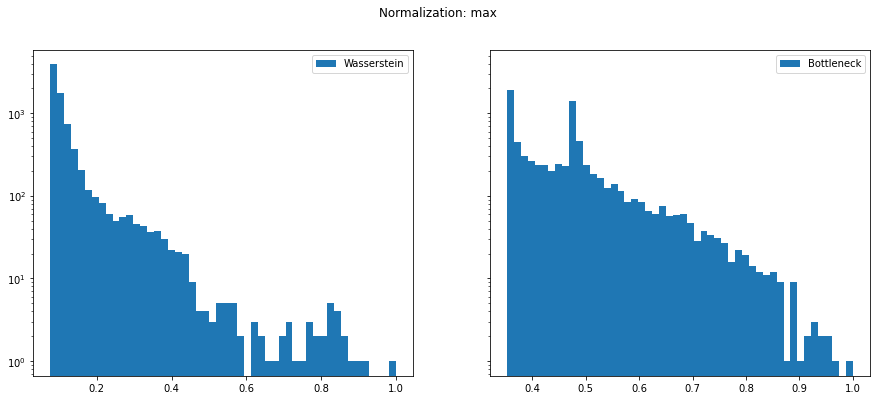

In [134]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))

max = 1e-0

fig.suptitle(f"Normalization: {norm}")
_ = axs[0].hist(
    w_score, bins=50, range=(np.nanmin(w_score), max),
    label="Wasserstein",
)
_ = axs[1].hist(
    b_score, bins=50, range=(np.nanmin(b_score), max),
    label="Bottleneck",
    # color="red", alpha=0.5,
)

for ax in axs:
    # ax.set_xscale("log")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 0))
    ax.set_yscale("log")
    ax.legend()

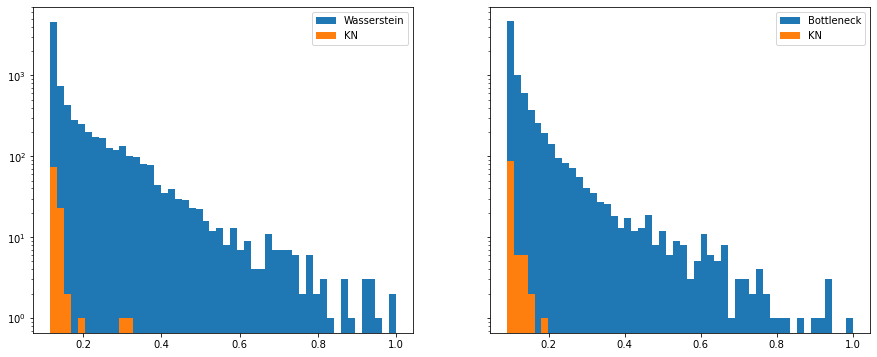

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))
n_bins = 50
max = 1e-0

_ = axs[0].hist(
    w_score, bins=n_bins, range=(np.nanmin(w_score), max),
    label="Wasserstein",
)


_ = axs[1].hist(
    b_score, bins=n_bins, range=(np.nanmin(b_score), max),
    label="Bottleneck",
    # color="red", alpha=0.5,
)

for target in [64]:

    w_score_target = scores_of_target(
        target, w_score, meta_data, idx_id_w_dist
    )

    _ = axs[0].hist(
        w_score_target, bins=n_bins, range=(np.nanmin(w_score), max),
        label=CLASSES[target],
    )

    b_score_target = scores_of_target(
        target, b_score, meta_data, idx_id_b_dist
    )

    _ = axs[1].hist(
        b_score_target, bins=n_bins, range=(np.nanmin(b_score), max),
        label=CLASSES[target],
    )

for ax in axs:
    # ax.set_xscale("log")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 0))
    ax.set_yscale("log")
    ax.legend()

Bottleneck distance

# Explore anomalies and compare

In [112]:
lcs, mjds = lcs_from_plasticc(raw_df=lcs, passband="g")

In [113]:
rank_w = np.argsort(w_score)
rank_b = np.argsort(b_score)

In [114]:
from astropology.plasticc import rank_to_object_id

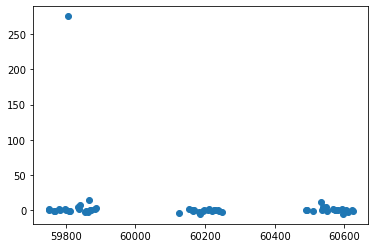

In [115]:
rank = -7
object_id = rank_to_object_id(rank, w_score, idx_id_w_dist)
# mask_negative = lcs[tata] >= 0
# plt.scatter(mjds[tata][mask_negative], lcs[tata][mask_negative])
plt.scatter(mjds[object_id], lcs[object_id])

Wasserstein vs Bottleneck

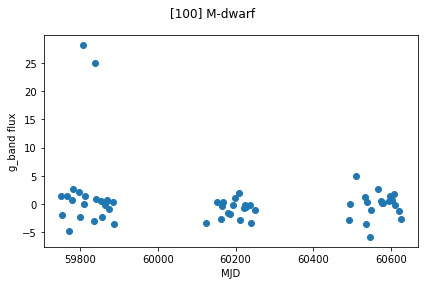

In [116]:
fig, ax = plt.subplots(tight_layout=True)

save_to = "/home/edgar/astropology/img/"

if "no_mask" in matrix_directory:
    save_to = f"/home/edgar/astropology/img/no_mask/{norm}"
else:
    save_to = f"/home/edgar/astropology/img/mask/{norm}"

if os.path.exists(save_to) is False:
    os.makedirs(f"{save_to}/bottleneck")
    os.makedirs(f"{save_to}/wasserstein")

for rank in range(1, 101):

    object_id = rank_to_object_id(-rank, b_score, idx_id_b_dist)
    target = meta_data.loc[object_id, "target"]
    ax.clear()

    fig.suptitle(f"[{rank}] {CLASSES[target]}")
    ax.set_xlabel("MJD")
    ax.set_ylabel(f"{band} flux")


    ax.scatter(mjds[object_id], lcs[object_id])
    
    fig.savefig(f"{save_to}/bottleneck/{rank:03d}_bottleneck_{norm}_{band}.pdf")

for rank in range(1, 101):

    object_id = rank_to_object_id(-rank, w_score, idx_id_w_dist)
    target = meta_data.loc[object_id, "target"]
    ax.clear()

    fig.suptitle(f"[{rank}] {CLASSES[target]}")
    ax.set_xlabel("MJD")
    ax.set_ylabel(f"{band} flux")
    ax.scatter(mjds[object_id], lcs[object_id])
    fig.savefig(f"{save_to}/wasserstein/{rank:03d}_wasserstein_{norm}_{band}.pdf")